# New York Fare Classification

Objectives 
- learn embeddings
- learn dropout
- serve as another case study

Embedding
- a very powerful concept
- replaces label-encoding and one-hot encoding
  - label-encoding:  turns category into numbers
  - one-hot encodings: turns category into cols
- In neural network, we don't have to....
  - we instead assign a vector of numbers for each category
  - Let's say I have 1000 samples, one col with two categories (morning, afternoon)
    - SHAPE: (1000, 1)
  - for nn ,we can create vector first with randoms
    - to represent each category
      -EX 
        - Morning : [1,5,.3,2,5]
        - afternoon: [4,3,.2,1,.9]
  - So shape change from 1000,1 to 1000,1,5

In [1]:
import torch

In [2]:
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

In [3]:
df = pd.read_csv('./NYCTaxiFares.csv')

In [4]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [17]:
import datetime as dt

In [7]:
df.fare_class.value_counts(normalize=True)

# valie 0 = -> less than 10 dollar
# value 1 mean otherwise

0    0.666667
1    0.333333
Name: fare_class, dtype: float64

# 2.EDA 
we so lazy always so skip

# 3 Feature Eng

### Calculate the distance traveled
The <a href='https://en.wikipedia.org/wiki/Haversine_formula'>haversine formula</a> calculates the distance on a sphere between two sets of GPS coordinates.<br>
Here we assign latitude values with $\varphi$ (phi) and longitude with $\lambda$ (lambda).

The distance formula works out to

${\displaystyle d=2r\arcsin \left({\sqrt {\sin ^{2}\left({\frac {\varphi _{2}-\varphi _{1}}{2}}\right)+\cos(\varphi _{1})\:\cos(\varphi _{2})\:\sin ^{2}\left({\frac {\lambda _{2}-\lambda _{1}}{2}}\right)}}\right)}$

where

$\begin{align} r&: \textrm {radius of the sphere (Earth's radius averages 6371 km)}\\
\varphi_1, \varphi_2&: \textrm {latitudes of point 1 and point 2}\\
\lambda_1, \lambda_2&: \textrm {longitudes of point 1 and point 2}\end{align}$

In [8]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [9]:
# df['dist_km'] = haversine_distance(df,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
# df.head()
df['hav_dis'] = haversine_distance(df,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hav_dis
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


In [10]:
df.hav_dis.describe()

count    120000.000000
mean          3.322160
std           3.337004
min           0.010208
25%           1.316428
50%           2.237084
75%           4.034564
max          28.846365
Name: hav_dis, dtype: float64

In [11]:
import seaborn

/Users/atichetsurakul/opt/anaconda3/envs/ai50/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


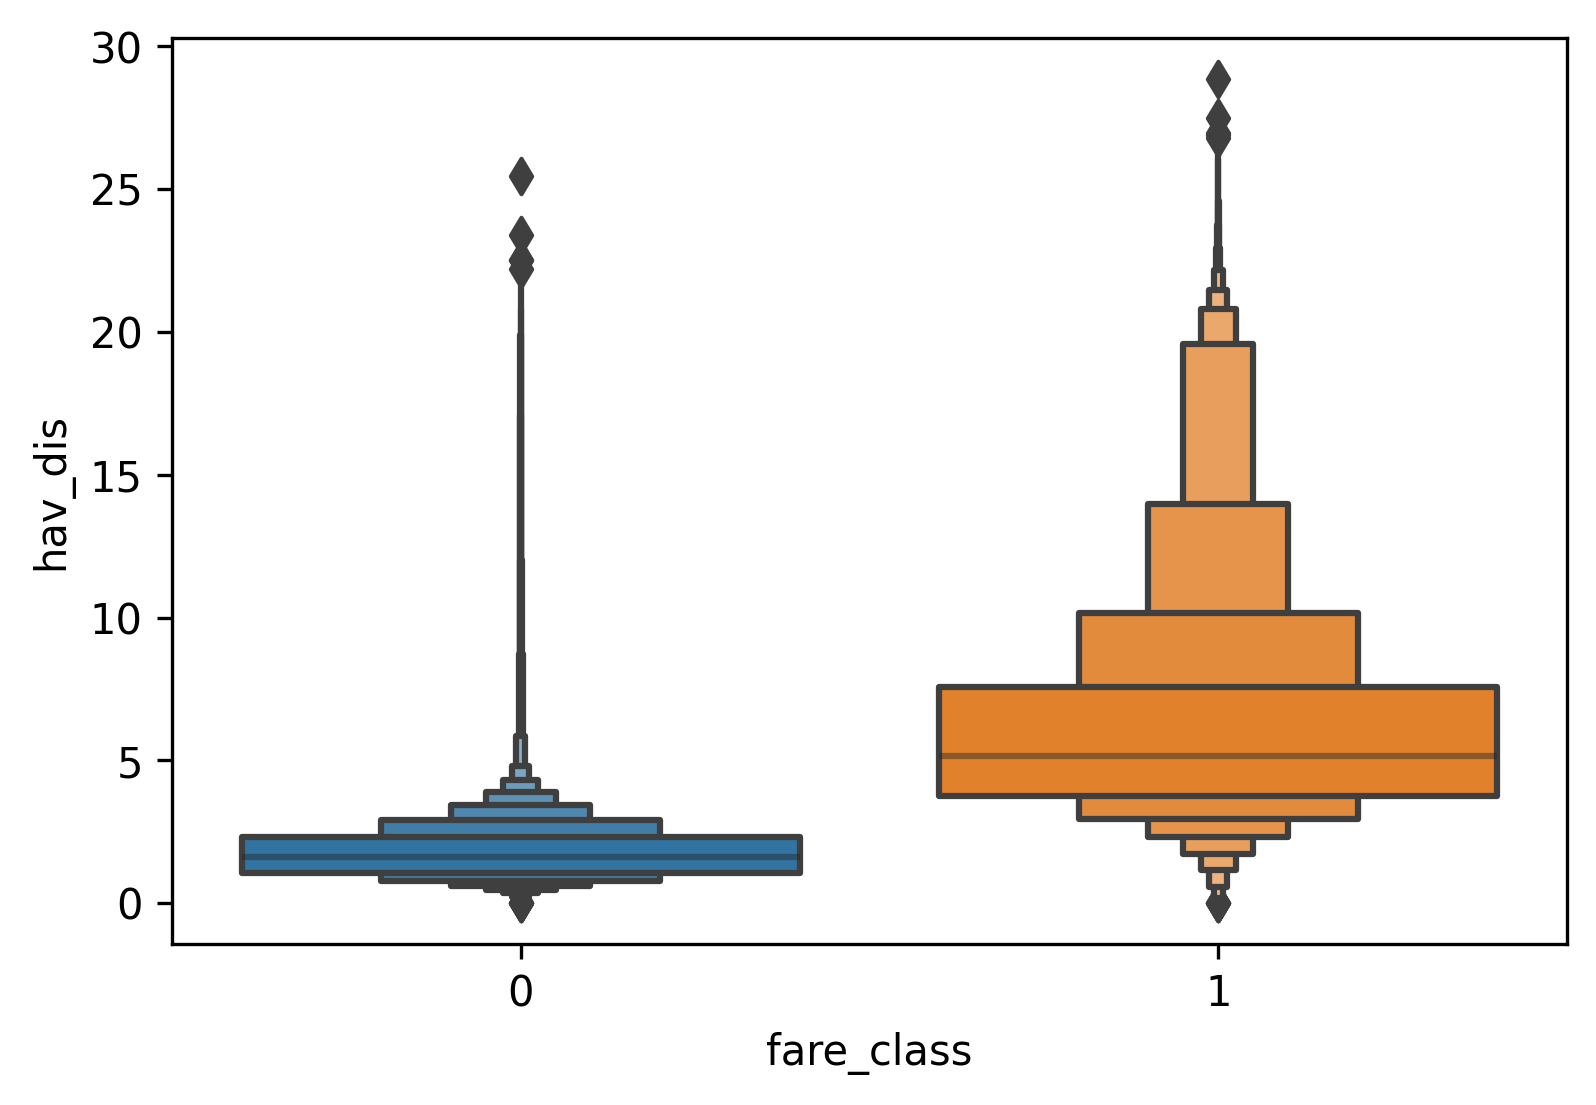

In [15]:
plt.figure(dpi=300)
seaborn.boxenplot(df.fare_class,df.hav_dis)

plt.show()

# 4.Feature Extraction

1. convert UTC to Newyprk time
2. extract hours,am,pm,day as feature

In [19]:
df['ny_time']=pd.to_datetime(df['pickup_datetime'].str[:19]) - pd.Timedelta(hours=-4)

In [20]:
df['hour'] = df.ny_time.dt.hour
df['day'] = df.ny_time.dt.strftime('%a')
df['ampm'] = np.where(df['hour'] < 12 ,'am','pm')

In [42]:
assert len(df.hour.unique()) <= 24,'hour range'
assert df.hour.min() == 0, 'hihourmin'
assert df.hour.max() == 23, 'hihourmax'


assert len(df.day.value_counts()) == 7, 'hiday'


assert (df.ampm.unique() == np.array(['pm','am'])).all(), 'hi'

In [41]:
# 
df.ampm.unique()

array(['pm', 'am'], dtype=object)

In [43]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'hav_dis', 'ny_time', 'hour', 'day', 'ampm'],
      dtype='object')

## columns name

In [44]:
cat_cols = ['hour','ampm','day']
cont_cols = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','passenger_count', 'hav_dis']
y = ['fare_class']

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   pickup_datetime    120000 non-null  object        
 1   fare_amount        120000 non-null  float64       
 2   fare_class         120000 non-null  int64         
 3   pickup_longitude   120000 non-null  float64       
 4   pickup_latitude    120000 non-null  float64       
 5   dropoff_longitude  120000 non-null  float64       
 6   dropoff_latitude   120000 non-null  float64       
 7   passenger_count    120000 non-null  int64         
 8   hav_dis            120000 non-null  float64       
 9   ny_time            120000 non-null  datetime64[ns]
 10  hour               120000 non-null  int64         
 11  day                120000 non-null  object        
 12  ampm               120000 non-null  object        
dtypes: datetime64[ns](1), float64(6), int64(3), 

## 5. CATEGORIES

In [47]:
for col in cat_cols:
    df[col] = df[col].astype('category')

In [49]:
df.ampm.unique()

['pm', 'am']
Categories (2, object): ['am', 'pm']

In [52]:
df.ampm.cat.codes.values

array([1, 1, 1, ..., 1, 1, 1], dtype=int8)

# 6. Cleaning

# 7 Define X and y

# stack the hours, ampm, and day as one vector


In [57]:

hr = df.hour.cat.codes.values
ampm = df.ampm.cat.codes.values
day = df['day'].cat.codes.values

time = np.stack([hr,ampm,day],1)
time[:5]
time.shape

(120000, 3)

In [71]:
# convert to tensor

time = torch.tensor(time, dtype = torch.int64)

In [72]:
time

tensor([[12,  1,  1],
        [19,  1,  2],
        [15,  1,  2],
        ...,
        [22,  1,  3],
        [12,  1,  5],
        [20,  1,  2]])

In [68]:
lat1 = df['pickup_latitude'].values
lat2 = df.dropoff_latitude.values
long1 = df.pickup_longitude.values
long2 = df.dropoff_longitude.values
ps_count = df.passenger_count.values
hav_dis = df.hav_dis.values

conts = np.stack([lat1,lat2,long1,long2,ps_count,hav_dis],1)

In [69]:
conts = torch.tensor(conts)

In [76]:
conts[:4],conts.shape

(tensor([[ 40.7305,  40.7447, -73.9924, -73.9755,   1.0000,   2.1263],
         [ 40.7406,  40.7441, -73.9901, -73.9742,   1.0000,   1.3923],
         [ 40.7511,  40.7662, -73.9941, -73.9601,   2.0000,   3.3268],
         [ 40.7564,  40.7482, -73.9905, -73.9712,   1.0000,   1.8641]],
        dtype=torch.float64),
 torch.Size([120000, 6]))

In [75]:
y = torch.tensor(df.fare_class.values).flatten()
y.shape

torch.Size([120000])

## 8. Determine the embedding size

In [77]:
# get tge size of all my cate cols
cat_size = [len(df[col].cat.categories) for col in cat_cols]

[24, 2, 7]